In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm

from tqdm import tqdm

from kausal.generator import reaction_diffusion_2d
from kausal.koopman import *

# Generate dynamics 
This time we use explicit coupling between reaction-diffusion equation.

$$
\frac{\partial u}{\partial t} = D_u \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) - u (u - a)(u - 1) + \beta v,
$$

$$
\frac{\partial v}{\partial t} = D_v \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) - v (v - b)(v - 1) + \gamma u.
$$

With coupling terms, and the following conditions for causal direction: if $\beta = 0$, $u \rightarrow v$ ; else if $\gamma = 0$, $v \rightarrow u$.

__Here, we use $\gamma = 0$, with the causal direction $v \rightarrow u$.__

In [3]:
# Spatial domain
Lx, Ly = 1.0, 1.0
Nx, Ny = 16, 16
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
X, Y = torch.meshgrid(
    torch.linspace(0, Lx, Nx), 
    torch.linspace(0, Ly, Ny), 
    indexing="ij"
)

# Time span
t0, t1 = 0.0, 10.0
dt = 0.001 

# Parameters
D_u, D_v = 0.1, 0.1  # Diffusion coefficients
a, b = 0.3, 0.3  # Reaction parameters

# Stability constraint for time step
max_dt = min(dx**2 / (2 * D_u), dy**2 / (2 * D_u))
dt = min(dt, max_dt)
steps = int((t1 - t0) / dt)

# Initial conditions
u_init = a + 0.1 * torch.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near a
v_init = b + 0.1 * torch.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near b
initial_state = torch.cat([u_init.ravel(), v_init.ravel()])

# Coupling coefficients
beta, gamma = 10.0, 0.0  # gamma = 0 (v --> u), beta = 0 (u --> v)
params = (D_u, D_v, a, b, beta, gamma, Nx, Ny, dx, dy)


In [4]:
# Integration
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: reaction_diffusion_2d(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method='dopri5',
        options={'max_num_steps': 100000}
    )
    return t, solution

t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract solutions for u and v
omega_1 = solution[:, :Nx * Ny].T.reshape((1, Nx, Ny, steps)) # U
omega_2 = solution[:, Nx * Ny:].T.reshape((1, Nx, Ny, steps)) # V


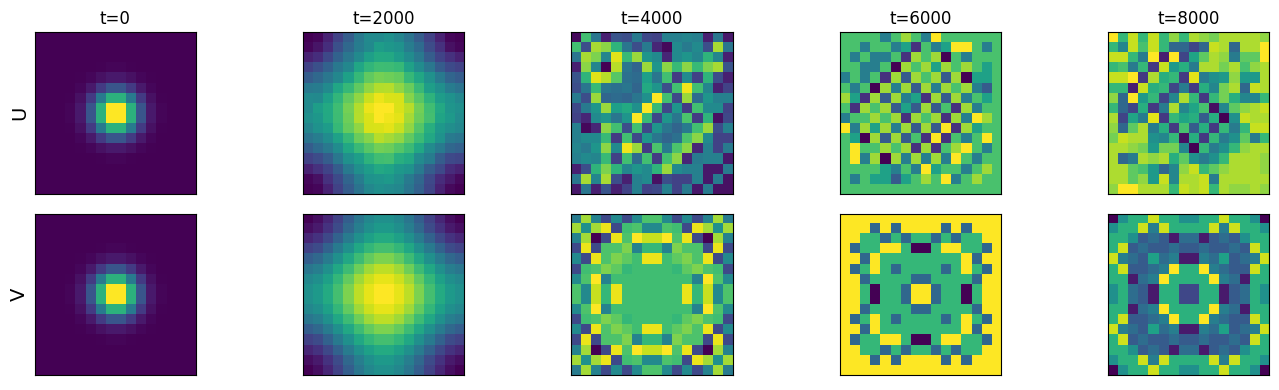

In [5]:
# Plot
n_plot = 5
n_skip = steps // n_plot
f, ax = plt.subplots(2, n_plot, figsize=(14,4))

for i in range(n_plot):
    ax[0,i].imshow(omega_1[0, :, :, ::n_skip][:, :, i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f't={i*n_skip}')
    
    ax[1,i].imshow(omega_2[0, :, :, ::n_skip][:, :, i])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

ax[0,0].set_ylabel('U', fontsize=14)
ax[1,0].set_ylabel('V', fontsize=14)
plt.tight_layout()
plt.show();


# Causal Koopman

100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:02<00:00,  3.07s/it]


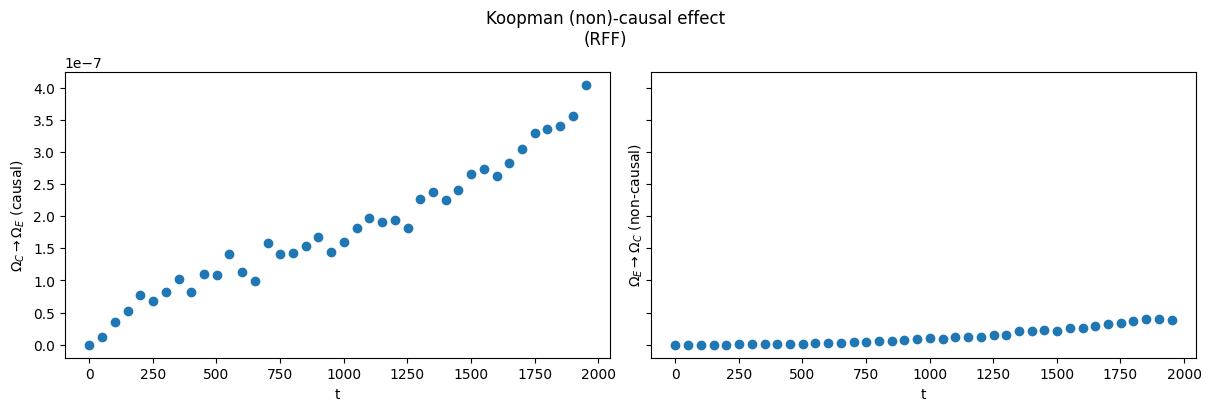

In [6]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    ## 1. Causal loss
    causal_loss, _, _ = compute_causal_loss(
        cause = omega_2, 
        effect = omega_1,
        t = t
    )

    ## 2. Non-causal loss
    non_causal_loss, _, _ = compute_causal_loss(
        cause = omega_1, 
        effect = omega_2,
        t = t
    )
    
    losses['causal'].append(causal_loss)
    losses['non_causal'].append(non_causal_loss)

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, losses['causal'])
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, losses['non_causal'])
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle('Koopman (non)-causal effect\n(RFF)')
plt.show();


# Deep Causal Koopman

Using neural network (encoder-decoder __CNN__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the functional.

In [7]:
from kausal.observables import CNNFeatures

In [8]:
# Hyperparameters
hidden_channels = [16, 32, 64, 128]
lr = 1e-4
epochs = 50
batch_size = 32

# Utility function
transform_2d = lambda x: x.permute(3, 0, 1, 2) # Transform into CNN-compatible shape of (T, C, H, W)


In [9]:
# 1. Causal direction
## Dataset prep
cause = transform_2d(omega_2)
effect = transform_2d(omega_1)
effect_cause = torch.cat([effect, cause], axis=1)
n_train = int(0.8 * steps)

## Initialize models
marginal_model_ce = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1)
joint_model_ce = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1)

## Fit models
marginal_loss_ce = marginal_model_ce.fit(
    x = effect[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = batch_size
)

joint_loss_ce = joint_model_ce.fit(
    x = effect_cause[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = batch_size
)


100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


In [10]:
# 2. Non-causal direction
## Dataset prep
cause = transform_2d(omega_1)
effect = transform_2d(omega_2)
effect_cause = torch.cat([effect, cause], axis=1)
n_train = int(0.8 * steps)

## Initialize models
marginal_model_ec = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1)
joint_model_ec = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1)

## Fit models
marginal_loss_ec = marginal_model_ec.fit(
    x = effect[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = batch_size
)

joint_loss_ec = joint_model_ec.fit(
    x = effect_cause[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = batch_size
)


100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


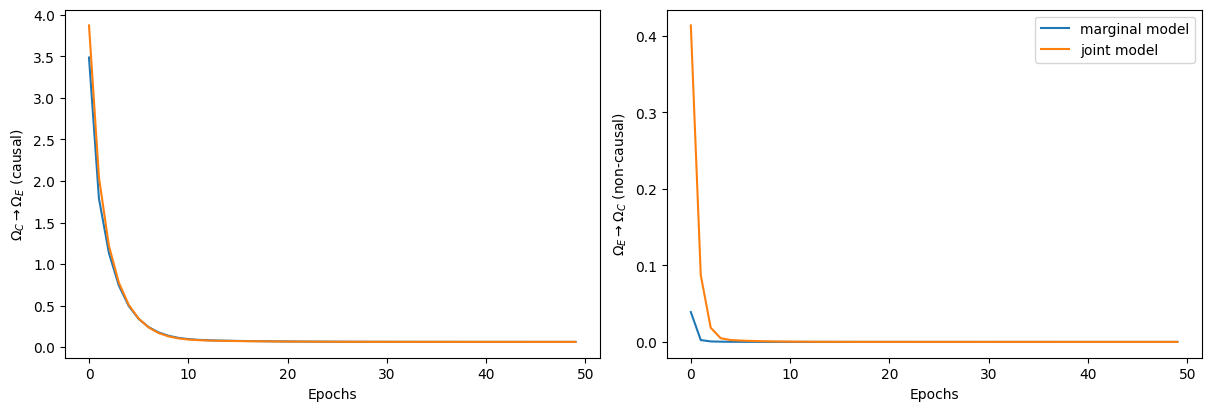

In [11]:
# Plot losses
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].plot(marginal_loss_ce, label='marginal model')
ax[0].plot(joint_loss_ce, label='joint model')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].plot(marginal_loss_ec, label='marginal model')
ax[1].plot(joint_loss_ec, label='joint model')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

plt.legend()
plt.show();


100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.41it/s]


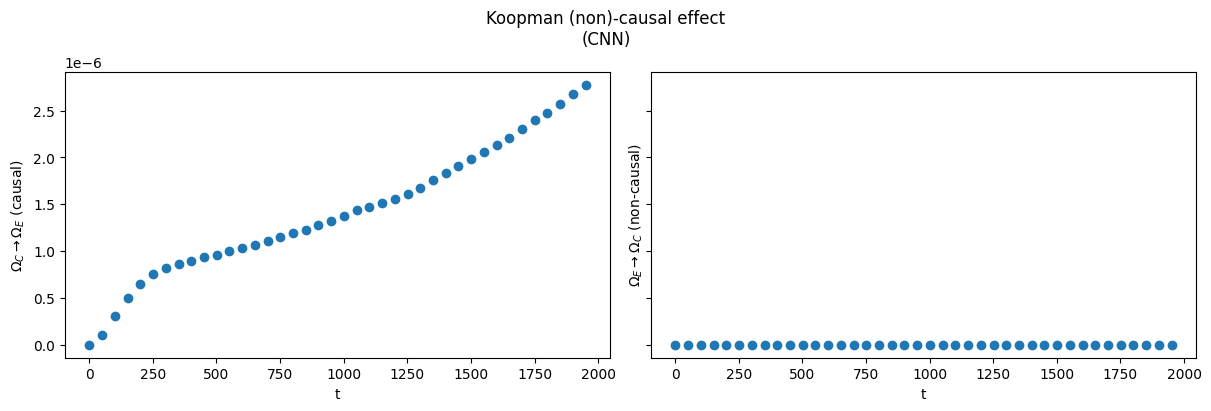

In [12]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    with torch.no_grad():

        ## 1. Causal loss
        causal_loss, _, _ = compute_causal_loss(
            cause = omega_2, 
            effect = omega_1,
            t = t,
            marginal_model = marginal_model_ce,
            joint_model = joint_model_ce
        )

        ## 2. Non-causal loss
        non_causal_loss, _, _ = compute_causal_loss(
            cause = omega_1, 
            effect = omega_2,
            t = t,
            marginal_model = marginal_model_ec,
            joint_model = joint_model_ec
        )
    
    losses['causal'].append(causal_loss)
    losses['non_causal'].append(non_causal_loss)

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, losses['causal'])
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, losses['non_causal'])
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle('Koopman (non)-causal effect\n(CNN)')
plt.show();
